In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *
from stargazer import stargazer
from sklearn.metrics import mean_squared_error, r2_score

In [59]:
import copy
from typing import List
import numpy.typing as npt
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import rmse
def ols_crossvalidator(
    formula: str, data: pd.DataFrame, n_folds=5, average_rmse=True
) -> dict:
    """OLS cross-validator


    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.

    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.

    """

    # Get dependent variable

    y = formula.split("~")[0].strip()

    # Get statistics on the whole work data

    model = smf.ols(formula, data=data).fit()

    rsquared = model.rsquared
    # n_coefficients = model.params.shape[0]
    n_coefficients = (
        model.df_model + 1
    )  # This might differ from model.params.shape[0], because of collinear predictors
    bic = model.bic
    rmse_alldata = rmse(model.predict(), data[y])

    # Calculating test and train RMSE-s for each fold

    k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

    rmse_train = []
    rmse_test = []

    for train_index, test_index in k.split(data):

        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        model = smf.ols(formula, data=data_train).fit()

        rmse_train.append(rmse(data_train[y], model.predict(data_train)))
        rmse_test.append(rmse(data_test[y], model.predict(data_test)))

    if average_rmse:
        rmse_train = np.mean(rmse_train)
        rmse_test = np.mean(rmse_test)

    return {
        "RMSE": rmse_alldata,
        "R-squared": rsquared,
        "BIC": bic,
        "Coefficients": n_coefficients,
        "Training RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }


import statsmodels


def point_predict_with_conf_int(
    regression: statsmodels.regression.linear_model.RegressionResultsWrapper,
    new_datapoint: pd.DataFrame,
    interval_precision=0.95,
    round_n=2,
) -> dict:
    """
    Does point prediction and interval prediction for a new datapoint.

        Parameters
    ----------
    regression : statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted regression model.
    new_datapoint : pd.DataFrame
        Database containing a new observation.
    interval_precision : float, default=0.95
        Precision of interval prediction.
    round_n: int, default=2
        Decimals to round floats in output.
    """

    summaryframe = regression.get_prediction(new_datapoint).summary_frame(
        alpha=1 - interval_precision
    )

    point_prediction = round(summaryframe["mean"].values[0], round_n)

    conf_int = [
        round(i, round_n)
        for i in summaryframe[["obs_ci_lower", "obs_ci_upper"]].values[0]
    ]

    if round_n == 0:
        point_prediction = int(point_prediction)
        conf_int = [int(i) for i in conf_int]
    else:
        pass

    return {
        "Point prediction": point_prediction,
        f"Prediction Interval ({round(interval_precision*100)}%)": conf_int,
    }


In [60]:
data = pd.read_csv("/Users/jacopobinati/Desktop/Prediction ML/assignment1/DA3-phdma/HM1/morg-2014-emp.csv")
data.head()
#Data imported correctly since we have 149316 observations

/var/folders/6t/d3d0rh5d1rd426bk9g_mnhd00000gn/T/ipykernel_78968/920692788.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.


,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


We will keep only workers in the cathegory: Editors. 
The Census Code is: 2830

In [61]:
# CLEANING AND CREATION OF NEW VARIABLE

data = data[(data['occ2012'] == 2830)]
summary = data.describe()
summary_code = data['occ2012'].describe()
summary1 = data['lfsr94'].describe()

# create the variable
data['w'] = data['earnwke'] / data['uhours']
data['lnw'] = np.log(data['w'])
data['agesqr'] = data['age']**2

#rewrite the variable sex as follows: 1 for Male and 0 for Female
data['sex'] = data['sex'].replace({1: 1, 2: 0})
data = data[data['lfsr94'] == "Employed-At Work"]


summary_code = data['occ2012'].describe()
summary1 = data['lfsr94'].describe()

In [62]:
# create a new var which create a list of values for each state
states = sorted(data['stfips'].unique())
state_code = {state: code for code, state in enumerate(states, start=1)}
data['state_code'] = data['stfips'].map(state_code)

# Getting some insights regarding the dataset
columns_of_interest = ['earnwke', 'uhours', 'w', 'agesqr'] 
specific_columns_stats = data[columns_of_interest].describe()


print(specific_columns_stats)
print(state_code)
data['sex'].value_counts()

           earnwke      uhours           w       agesqr
count   152.000000  152.000000  152.000000   152.000000
mean   1099.228355   38.611842   28.665901  1735.223684
std     654.002655    9.550874   19.121826  1020.689464
min      30.000000    4.000000    2.692000   256.000000
25%     694.800000   40.000000   17.734937   841.000000
50%     961.530000   40.000000   24.719500  1521.000000
75%    1442.300000   40.000000   34.973682  2425.750000
max    2884.610000   60.000000  171.794667  4096.000000
{'CA': 1, 'CO': 2, 'CT': 3, 'DC': 4, 'DE': 5, 'FL': 6, 'GA': 7, 'HI': 8, 'IA': 9, 'ID': 10, 'IL': 11, 'IN': 12, 'KS': 13, 'LA': 14, 'MA': 15, 'MD': 16, 'ME': 17, 'MI': 18, 'MN': 19, 'MO': 20, 'MS': 21, 'MT': 22, 'ND': 23, 'NE': 24, 'NH': 25, 'NJ': 26, 'NM': 27, 'NV': 28, 'NY': 29, 'OH': 30, 'OR': 31, 'PA': 32, 'SC': 33, 'TN': 34, 'TX': 35, 'UT': 36, 'VA': 37, 'VT': 38, 'WA': 39, 'WI': 40, 'WY': 41}


1    77
0    75
Name: sex, dtype: int64


Now we have:
1) chosen a working category which, in this case, is 2830, "Editors".
2) Cleaned and organized the dataset
    2.1) in the two graph we can see how there a different distribution of wages between female and male.
3) we extrapplate some insight from the dataset, which from the original 149316 observations, now has 152.
4) We are able to visualize data using python libraries such as matplotlib and seaborn.
5) check for the kurtuosis and the values if it's high maybe there are outliers values.

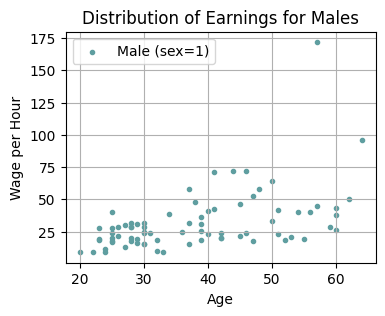

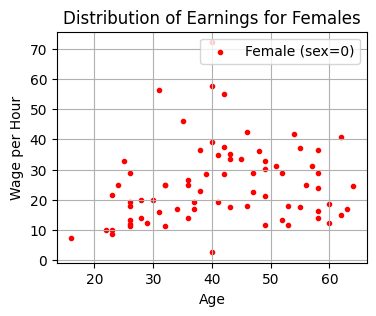

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


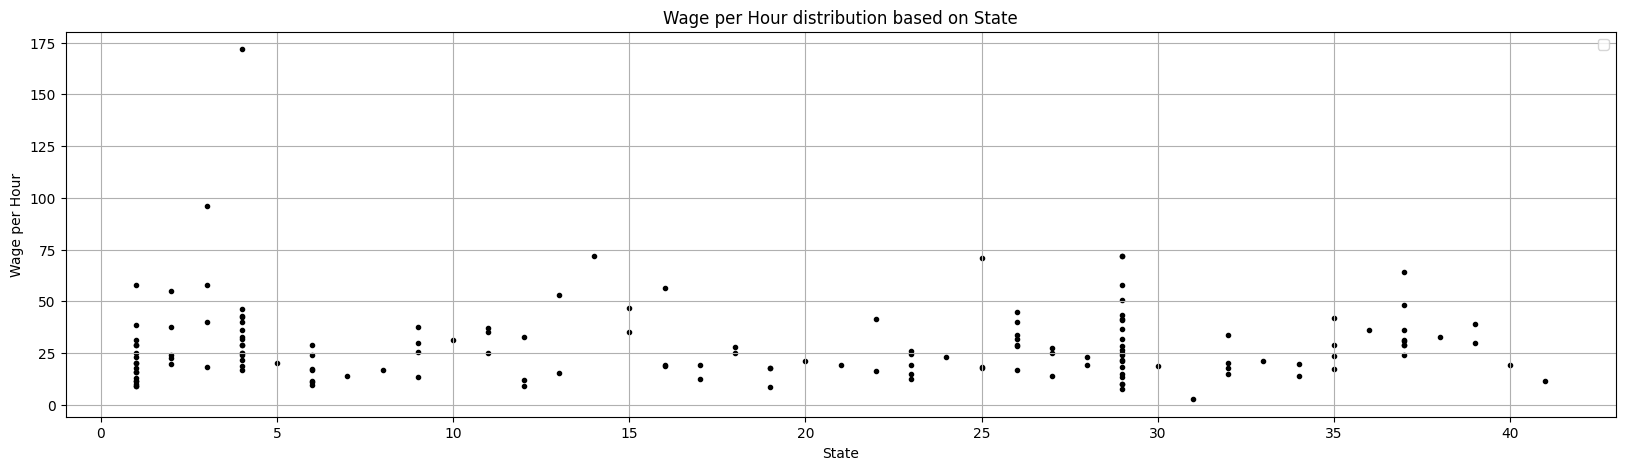

In [63]:
data_male = data[data['sex'] == 1]
data_female = data[data['sex'] == 0]
plt.figure(figsize=(4, 3))
plt.scatter(data_male['age'], data_male['w'], color='cadetblue', marker='.', label='Male (sex=1)')
plt.title('Distribution of Earnings for Males')
plt.xlabel('Age')
plt.ylabel('Wage per Hour')
plt.legend()
plt.grid(True)
plt.show()
#######
plt.figure(figsize=(4, 3))
plt.scatter(data_female['age'], data_female['w'], color='red', marker='.', label='Female (sex=0)')
plt.title('Distribution of Earnings for Females')
plt.xlabel('Age')
plt.ylabel('Wage per Hour')
plt.legend()
plt.grid(True)
plt.show()
#######
plt.figure(figsize=(20, 5))
plt.scatter(data['state_code'], data['w'], color='black', marker='.')
plt.title("Wage per Hour distribution based on State")
plt.xlabel('State')
plt.ylabel('Wage per Hour')
plt.legend()
plt.grid(True)
plt.show()

Right now we will work on the model selection. We will run 4 models in which we take into consideration variables such as: age, agesqr, sex, ownchild, grade92.
What we are interested in predict is the wage per hour which is defined as "w". 

In [64]:
# Linear regressions
model1 = "lnw ~ age + agesqr"
model2 = "lnw ~ age + agesqr + sex"
model3 = "lnw ~ age + agesqr + sex + ownchild"
model4 = "lnw ~ age + agesqr + sex + ownchild + grade92"

model_eq = [model1, model2, model3, model4]


In [65]:
regs = []
for equation in model_eq:
    regs.append(smf.ols(equation, data).fit(cov_type="HC1"))

stargazer.Stargazer(regs[:4])

In [68]:
n_fold = 5
cv_list = []
for equation in model_eq:
    cv_list.append(ols_crossvalidator(equation, data, n_fold, average_rmse=False))

In [72]:
pd.DataFrame(cv_list).round(2).assign(
    RMSE=lambda x: x["RMSE"].astype(int),
    BIC=lambda x: x["BIC"].astype(int),
    Coefficients=lambda x: x["Coefficients"].astype(int),
    Model=["Model " + str(i + 1) for i in range(len(model_eq))],
    Nvars=[1, 2, 5, 6, 6]
).loc[:, ["Model", "Nvars", "Coefficients", "R-squared", "RMSE", "BIC"]].set_index("Model")

ValueError: Length of values (5) does not match length of index (4)

In [70]:
pd.DataFrame(
    [cv["Test RMSE"] for cv in cv_list],
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]["Test RMSE"]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round().astype(int)

,Model 1,Model 2,Model 3,Model 4
Fold1,1,1,1,0
Fold2,1,1,1,1
Fold3,0,0,0,0
Fold4,0,0,0,0
Fold5,1,0,0,0
Average,1,0,0,0
